In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd
import seaborn as sns 
from typing import Optional
import matplotlib.pyplot as  plt
from pandas.core.common import random_state
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score,mean_squared_error

# Ignore warning messages 
import warnings
warnings.filterwarnings("ignore")

In [2]:
def random_sample_imputation(dataframe : pd.DataFrame, variable_name:str) -> None:
    """
    Imputes missing values in a column of a Pandas DataFrame
    using random sampling from the non-missing values.

    Args:
    - dataframe (pd.DataFrame): DataFrame containing the column to be imputed
    - variable_name (str): name of the column to be imputed

    Returns:
    - None
    """

    # Extract non-missing values from the specified column
    non_missing_values = dataframe[variable_name].dropna()

    # Generate random sample from non-missing values, with the same number of samples
    random_sample = non_missing_values.sample(dataframe[variable_name].isnull().sum(),
                                               random_state=0)

    # Assign the random sample to the missing values in the specified column
    random_sample.index = dataframe[dataframe[variable_name].isnull()].index
    dataframe.loc[dataframe[variable_name].isnull(), variable_name] = random_sample


In [3]:
def remove_null_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes null values from a pandas DataFrame by performing random sample imputation
    on all numerical features.

    Args:
        df (pandas.DataFrame): The DataFrame containing null values to be removed.

    Returns:
        pandas.DataFrame: The DataFrame with null values removed.
    """
    # Get list of numerical features in DataFrame
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
    
    # Perform random sample imputation on each numerical feature
    for feature in numerical_features:
        random_sample_imputation(df, feature)
    
    return df


In [4]:
def inter_quartile_range(df: pd.DataFrame, variable:str)-> pd.DataFrame:
    """
    This function computes the interquartile range (IQR) of a given variable in a dataframe,
    and removes any values that fall outside of the upper and lower limits.

    Args:
    - df: A pandas dataframe
    - variable: A string indicating the column name of the variable to be analyzed

    Returns:
    - A pandas dataframe with outliers removed from the specified variable
    """
    
    # Compute the first and third quartiles of the variable
    q1 = df[variable].quantile(0.5)
    q3 = df[variable].quantile(0.8)
    
    # Compute the IQR
    iqr = q3 - q1
    
    # Compute the lower and upper limits
    lower_bridge = df[variable].quantile(0.5) - (iqr * 1.5)
    upper_bridge = df[variable].quantile(0.8) + (iqr * 1.5)
    
    # Remove any values that fall outside of the upper and lower limits
    df.loc[df[variable] >= upper_bridge, variable] = upper_bridge
    df.loc[df[variable] <= lower_bridge, variable] = lower_bridge
    
    # Return the modified dataframe
    return df


In [5]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from the given dataframe.

    Args:
        df (pd.DataFrame): A pandas dataframe with numerical features.

    Returns:
        pd.DataFrame: A new dataframe with outliers removed from all numerical features.
    """
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
    for feature in numerical_features:
        df = inter_quartile_range(df, feature)
    return df


In [6]:
def run_model(i:int) -> dict:
    """
    Runs a random forest regression model on a specified column of a pandas DataFrame and returns the model and the RMSE.

    Args:
    i (int): The index of the target column to predict.

    Returns:
    dict: A dictionary containing the trained model and the RMSE value.
    """
    X = df.iloc[:,0].values.reshape(-1,1) # select the features as the first column of the DataFrame
    y = df.iloc[:,i].values # select the target column specified by the argument
    regressors = RandomForestRegressor() # initialize a random forest regressor
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split the data into training and test sets
    regressors.fit(X_train,y_train) # train the model
    y_hat = regressors.predict(X_test) # make predictions on the test set
    rmse= np.sqrt(mean_squared_error(y_test, y_hat)) # calculate the RMSE
    return {
        'model':regressors, # return the trained model
        'rmse':rmse # return the RMSE
    }

In [7]:
def plot_sns(df: pd.DataFrame) -> None:
    """
    Plot seaborn boxplots for a given DataFrame.
    
    Args:
    - df: a pandas DataFrame to be plotted. It should have numeric values in its columns.
    
    Returns:
    - None
    """
    
    # Set the size of the plot
    plt.figure(figsize=(16,5))
    
    # Melt the dataframe to convert it from wide to long format for plotting
    df_melted = pd.melt(df.iloc[:,2:])
    
    # Create a boxplot using seaborn
    my_plot = sns.boxplot(x='variable', y='value', data=df_melted)
    
    # Rotate the x-axis tick labels for better readability
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
    
    # No explicit return value, since the function plots the data directly
    return None

In [8]:
def show_null_values(df: pd.DataFrame) -> None:
    """
    Plot a bar chart of the count of null values for each column of a pandas DataFrame.
    
    Args:
    - df: a pandas DataFrame to be plotted.
    
    Returns:
    - None
    """
    
    # Count the null values for each column of the dataframe
    data = df.isnull().sum()
    
    # Create a new figure and axis for the bar chart
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    # Set the y-axis label
    ax.set_ylabel('count')
    
    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation='vertical')
    
    # Create a bar chart of the null value counts for each column
    ax.bar(df.columns, data)
    
    # Show the plot
    plt.show()
    
    # No explicit return value, since the function plots the data directly
    return None


In [9]:
df = pd.read_csv('/kaggle/input/grss-kol-hackathon-2023/train.csv') # load the DataFrame from a CSV file or another data source

In [10]:
# Extract the first 12 months from the 'MONTH' column of the DataFrame as a list
month_list = df.MONTH.iloc[:12,].tolist()

# Create a dictionary that maps integer values to months using the 'month_list' as values
inverse_transform = {x: y for x, y in enumerate(month_list)}

# Create a dictionary that maps months to integer values using the 'month_list' as keys
transform = {y: x for x, y in enumerate(month_list)}

# Apply the 'transform' dictionary to the 'MONTH' column of the DataFrame
df['MONTH'] = df['MONTH'].apply(lambda x: transform[x])

# Drop the 'YEAR' column from the DataFrame along the columns axis (axis=1)
df.drop('YEAR', axis=1, inplace=True)


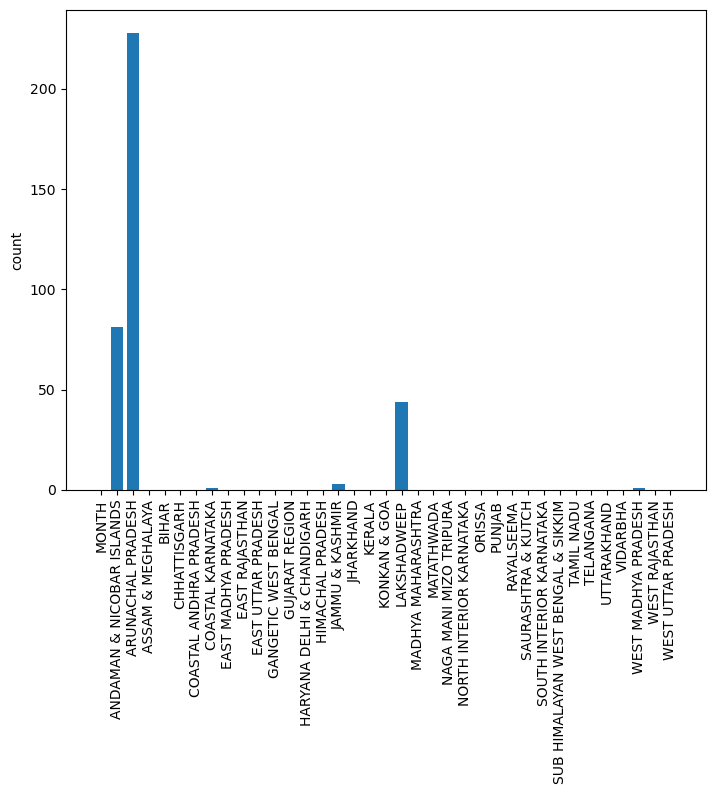

In [11]:
show_null_values(df)

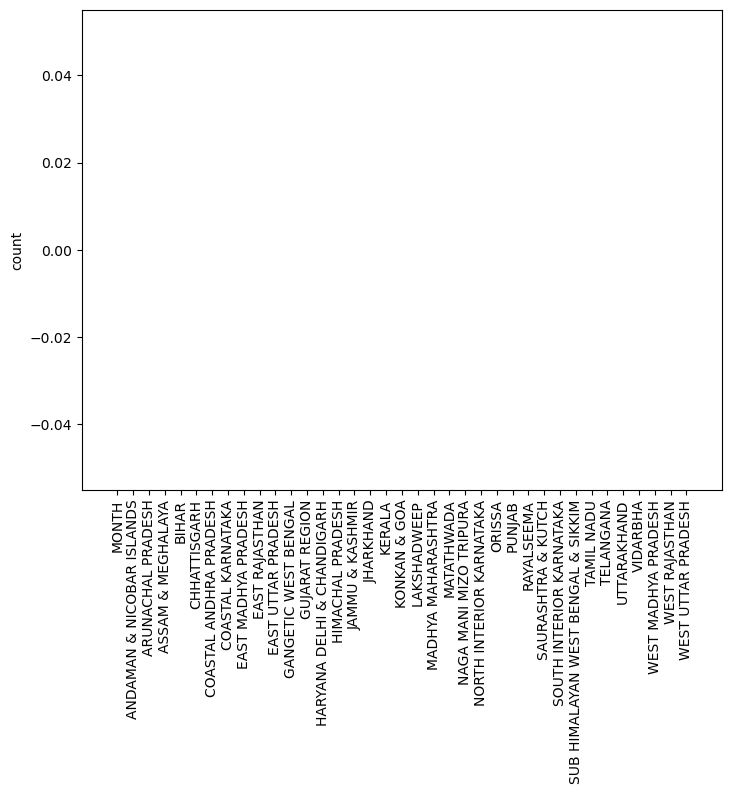

In [12]:
df = remove_null_values(df)
show_null_values(df)

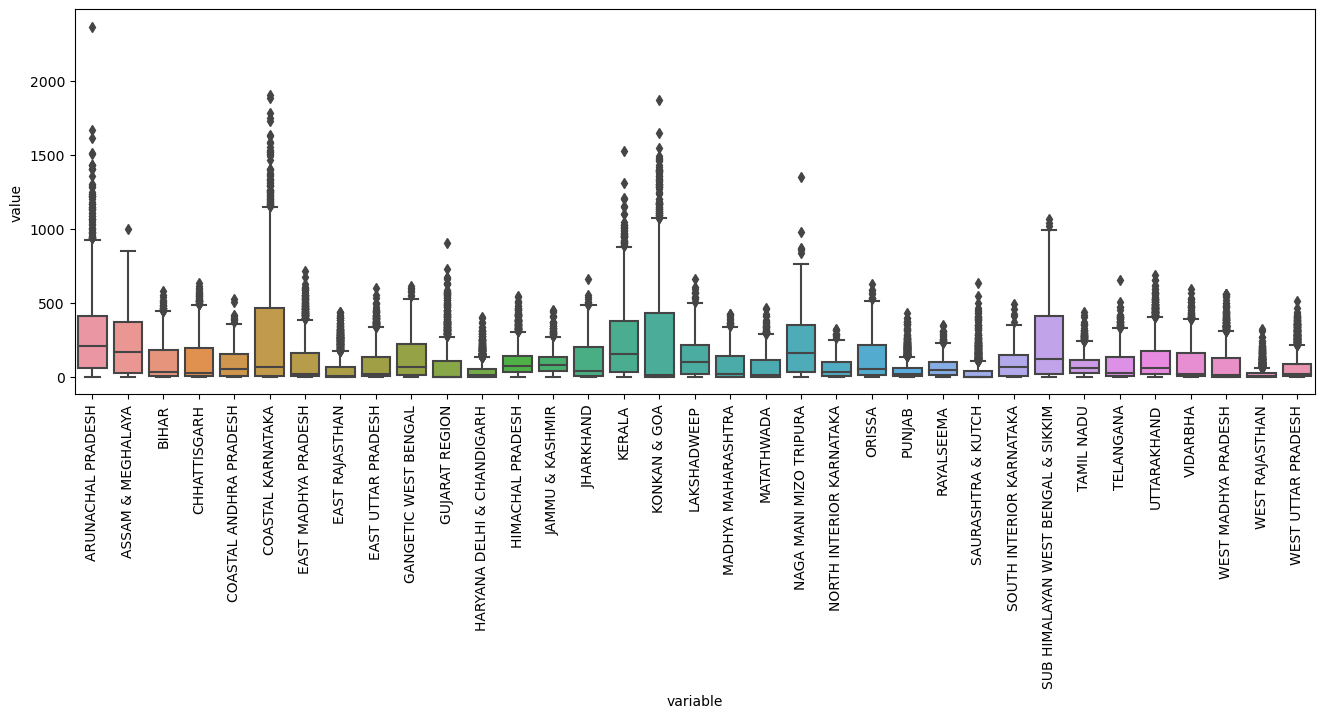

In [13]:
plot_sns(df);

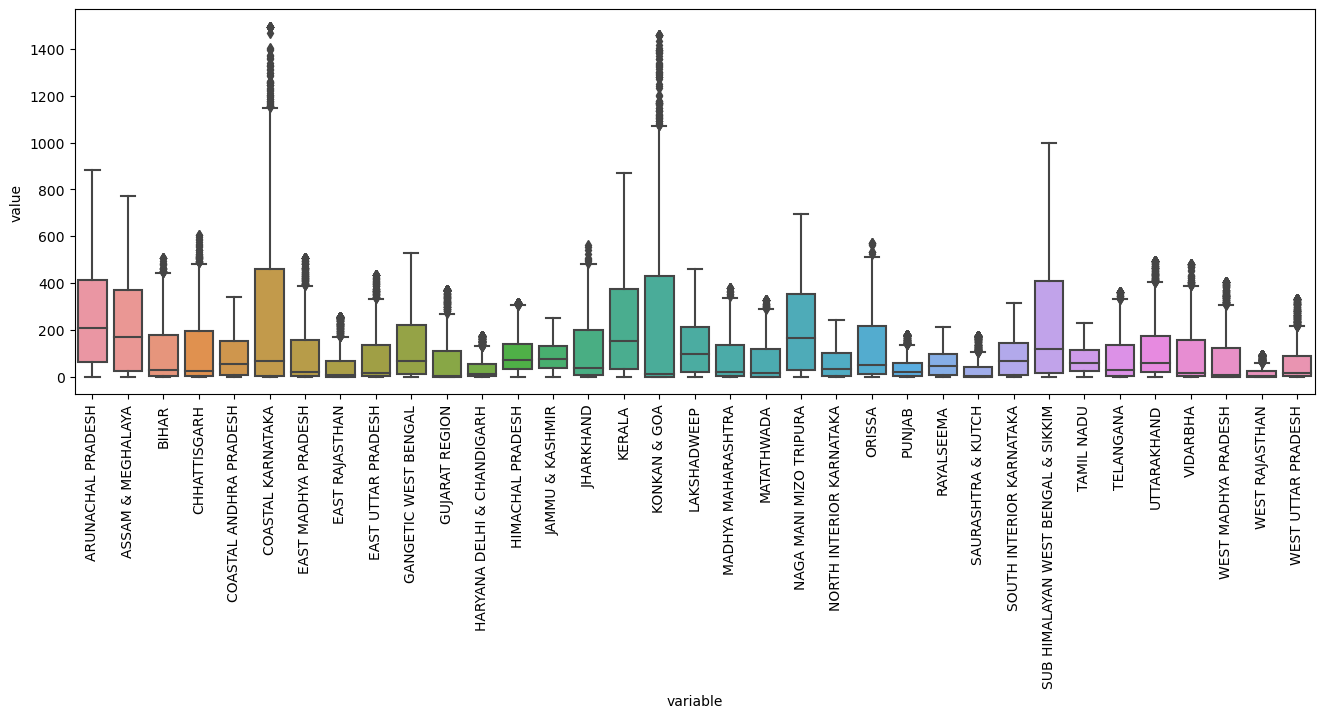

In [14]:
df = remove_outliers(df)
plot_sns(df);

In [15]:
model_run_df = pd.DataFrame(columns = ['range'])
model_run_df['range'] = [i for i in range(1,37)]
model_run_df['output'] = model_run_df['range'].apply(lambda x : run_model(x));

In [16]:
tmp_ = pd.DataFrame(list(model_run_df['output']))
model_run_df['rmse'] = tmp_['rmse']
model_run_df['model'] = tmp_['model']
model_run_df.drop('output',axis = 1,inplace = True)

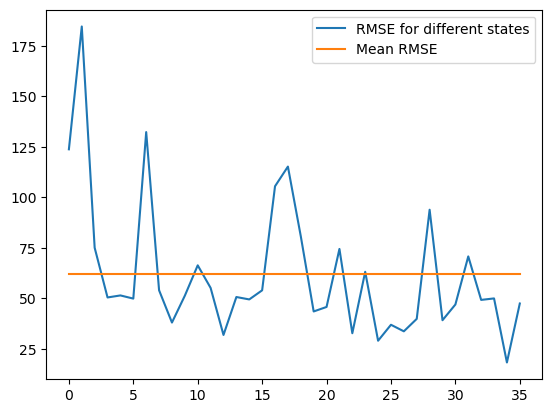

In [17]:
plt.plot(model_run_df.rmse,label = "RMSE for different states")
plt.plot(range(36),np.ones(36)*model_run_df.rmse.mean(),label = "Mean RMSE")
plt.legend()
plt.show()

In [18]:
prediction = model_run_df['model'].apply(lambda regressor : [regressor.predict(np.array(i).reshape(-1, 1)).squeeze() for i in inverse_transform.keys()])
prediction = pd.DataFrame(list(prediction))

In [19]:
prediction = prediction.T.reset_index()
assert len(prediction.columns) == len(df.columns)
prediction.columns = df.columns
prediction.MONTH = prediction.MONTH.apply(lambda x :inverse_transform[x])

In [20]:
prediction.to_csv('submission_csv.csv',index=False)

In [21]:
prediction.head()

,MONTH,ANDAMAN & NICOBAR ISLANDS,ARUNACHAL PRADESH,ASSAM & MEGHALAYA,BIHAR,CHHATTISGARH,COASTAL ANDHRA PRADESH,COASTAL KARNATAKA,EAST MADHYA PRADESH,EAST RAJASTHAN,...,SAURASHTRA & KUTCH,SOUTH INTERIOR KARNATAKA,SUB HIMALAYAN WEST BENGAL & SIKKIM,TAMIL NADU,TELANGANA,UTTARAKHAND,VIDARBHA,WEST MADHYA PRADESH,WEST RAJASTHAN,WEST UTTAR PRADESH
0,JAN,54.842023439102725,82.13161403166272,18.219989838953108,13.98288165630862,13.352513058064837,7.055093581425456,2.0522914269022596,18.717549468113507,6.8856698503083,...,1.1868761908269736,2.870991640130215,13.679228697637893,24.165388177194597,6.760188471982173,52.20210997917352,11.214933353833539,8.744548514106578,3.536030711065342,17.913275647208888
1,FEB,38.38206906954222,120.68356981852014,29.95754127485252,15.160495324126906,19.45991851532763,13.338621384910716,1.3135793918754988,19.240103560012564,5.716611593593284,...,1.429308722282256,4.669975611418023,24.62807585480061,13.953431421951644,9.87350857530988,61.20187650871985,12.371333420058715,7.585097818379975,5.171227555256388,18.809299853577425
2,MAR,55.36544859432563,192.62723666445476,78.21603138353929,9.79326989260382,15.475171080226337,13.37141779995178,6.61326501300165,13.248158312800177,4.376066206524916,...,1.2569026045991023,10.019025023686261,42.15284220778011,20.5744545869559,11.147282319884305,57.56587011228743,12.214733950879095,4.366574745479299,3.192405381217858,9.91239342828295
3,APR,82.26473065643997,259.10934940644387,203.16587244244988,17.860087562139277,16.396092427594116,24.99462556923721,30.70658656548037,6.927853427909277,2.851614844022692,...,1.2219161003067416,38.856638794145,115.21767489147747,46.059861835256015,18.96302396384076,34.39885110563713,10.166714614260318,2.4135577205985697,2.626466399805308,5.753628607715418
4,MAY,348.46907183904875,341.5086961912293,333.1478467771938,55.52125153314511,19.899506772655144,63.90865364485232,127.39280079271072,9.861380775803044,10.314093558528183,...,3.9435967375865704,91.45898624264704,267.30609091363516,69.46000345996646,25.265996650593415,52.67816385069711,12.360582622996244,7.2773257726785925,9.519877653923237,12.63650231218269
